### Import Libraries

In [1]:
import sys
sys.path.append("/work/b0990106x/trl/vc")
import importlib
import vc
importlib.reload(vc)
import torch
from vc.trainer_encodec_vc_inference import pack_inputs_v2, get_ar_prediction_get_audio, get_ar_prediction_audio_batch
from types import SimpleNamespace
from transformers import BartForConditionalGeneration, AutoTokenizer
from datasets import Dataset
from trl import DPOTrainer, DPOConfig, AutoModelForSeq2SeqLMWithValueHead, create_reference_model
from vc.encodec_model.nar_bart_model import NARBartForConditionalGeneration
from datetime import datetime
import os
import numpy as np
from dpo_eval import get_reward_claps ,eval_dpo_claps_batch, convert_array_to_tensor_format
import json
from tqdm import tqdm
import time
from typing import List, Tuple
import random
import argparse

sys.path.append('/work/b0990106x/trl/CLAPS')
from CLAPS.inference import load_model

/home/b0990106x/miniconda3/envs/trl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/b0990106x/.local/lib/python3.10/site-packages/s3prl/upstream/byol_s/byol_a/common.py:20: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


### Utility Functions

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [3]:
def generate_output_batch(
        ar_model, 
        nar_model, 
        ar_tokenizer, 
        nar_tokenizer, 
        clap_model,
        accelerator,
        src_encodec: list, 
        instruction: list, 
        args_predict: SimpleNamespace, 
        episode_counter: int = 0, 
        base_path: str = "/work/b0990106x/trl", 
        temperature: float = 1.0
) -> tuple[float, str]:
    '''
    Generates output from AR model, synthesize the audio, and evaluate the audio using NISQA.
    Returns:
        tuple:
            reward(float): The reward of the audio.
            tokenized_decode_ar(str): The tokenized output of the AR model - first layer.
    '''
    # Generate predictions using the AR model
    audio_list, decode_ar_list = get_ar_prediction_audio_batch(
        args_predict, ar_model, nar_model, ar_tokenizer, nar_tokenizer, src_encodec, instruction, episode_counter, temperature=temperature
    )
    # extract the instruction from the list 
    reward_list,tokenized_decode_ar_list = [], []

    for i, audio in enumerate(audio_list): 
        # audio ---> tensor([])
        if audio is not None:
            tensor_audio = convert_array_to_tensor_format(audio)
            if tensor_audio[0].shape[0]==1:
                tensor_audio[0] = tensor_audio[0].squeeze(0)
            # print(tensor_audio)
            reward = get_reward_claps(clap_model=clap_model, accelerator=accelerator, prompts = instruction[i], wavs = tensor_audio)
        else: 
            reward = 0
        reward_list.append(reward)
    
    for decode_ar in decode_ar_list:
        list_decode_ar = decode_ar.flatten().tolist()   
        filtered_decode_ar_list = list_decode_ar[2:-1]
        decode_ar_tokens = ar_tokenizer.convert_ids_to_tokens(filtered_decode_ar_list)
        tokenized_decode_ar = ar_tokenizer.convert_tokens_to_string(decode_ar_tokens)
        tokenized_decode_ar_list.append(tokenized_decode_ar)
        
    return reward_list, tokenized_decode_ar_list

def extract_data_from_json(file_path: str) -> Tuple[List[list], List[str], List[list]]:
    """
    Loads data from a JSON file and extracts 'src_encodec', 'instruction', and 'tgt_encodec'.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        tuple:
            all_src_encodec (List[list]): A list containing the 'src_encodec' data from each item in the JSON file.
            all_instruction (List[str]): A list containing the 'instruction' data from each item in the JSON file.
            all_tgt_encodec (List[list]): A list containing the 'tgt_encodec' data from each item in the JSON file.
    """
    with open(file_path, 'r') as f:
        data = json.load(f)

    all_src_encodec = [item["src_encodec"] for item in data]
    all_instruction = [item["instruction"] for item in data]

    return all_src_encodec, all_instruction

def train_model(
        model,
        model_ref,
        ar_tokenizer,
        train_dataset: Dataset,
        val_dataset: Dataset,
        model_output_dir: str,
        beta: float,
        resume_from_checkpoint: bool,
        model_checkpoint: str,
        learning_rate: float = 5e-07,
        num_train_epochs: int = 200,
        max_length: int = 1024*9,
        max_prompt_length: int = 1024*9,
        max_target_length: int = 1024*9,
        per_device_train_batch_size: int = 1,
        gradient_accumulation_steps: int = 1,
        seed: int = 42
) -> None:
    '''
    Train the DPO model and save the model.

    Args:
        model(AutoModelForSeq2SeqLMWithValueHead): The DPO model.
        model_ref(AutoModelForCausalLM): The reference model.
        ar_tokenizer(AutoTokenizer): The tokenizer.
        train_dataset(Dataset): The training dataset.
        val_dataset(Dataset): The validation dataset.
        model_output_dir(str): The output directory for the model.
        beta(float): The beta value.
        resume_from_checkpoint(bool): Whether to resume from a checkpoint.
        model_checkpoint(str): The path to the model

    Returns:
        None
    '''

    training_args = DPOConfig(
        beta = beta,
        output_dir = model_output_dir,
        resume_from_checkpoint = model_checkpoint if resume_from_checkpoint else None,
        seed = seed,
        per_device_train_batch_size = per_device_train_batch_size,
        num_train_epochs = num_train_epochs,
        gradient_accumulation_steps = gradient_accumulation_steps,
        learning_rate = learning_rate,
        max_length = max_length,
        max_prompt_length = max_prompt_length,
        max_target_length = max_target_length,
        evaluation_strategy="steps",
        save_steps = 5000,
        logging_dir = f"{model_output_dir}/logs"
    )
    
    trainer = DPOTrainer(
        model=model,
        ref_model=model_ref,
        args=training_args,
        tokenizer=ar_tokenizer,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )
    # Train the model
    trainer.train()

    # Save the model
    # trainer.save_model(f"{model_output_dir}/dpo_model")
    model.config.to_json_file(f"{model_output_dir}/config.json")
    # ar_tokenizer.save_pretrained(f"{model_output_dir}/dpo_model")


In [4]:
def process_data_batch(sample_size: int, 
                        ar_model, 
                        nar_model, 
                        ar_tokenizer, 
                        nar_tokenizer, 
                        clap_model,
                        accelerator,
                        selected_src_encodec: List[list], 
                        selected_instruction: List[str],
                        args_predict: SimpleNamespace, 
                        base_path: str = "/work/b0990106x/trl", 
                        temperature: float = 1.0, 
                        iteration: int = 0
) -> Tuple[List[str], List[str], List[str], List[float], List[float], List[float]]:
    # If sample size is 1, we cannot choose the best and worst outputs
    if sample_size < 2:
        raise ValueError("Parameter 'sample_size' must be greater than 1.")

    chosen, rejected, prompts, chosen_rewards, rejected_rewards, average_rewards = [], [], [], [], [], []

    disable_tqdm = not os.isatty(1)
    for i in tqdm(range(len(selected_src_encodec)), desc="Processing Data", disable=disable_tqdm):
        rewards, tokenized_outputs = [], []
        size_of_packed_input = (
            len(selected_src_encodec[i][0]) +
            len(ar_tokenizer(selected_instruction[i])["input_ids"][1:-1]) +
            3
        )
        if 4 < size_of_packed_input <= 1024:
            selected_src_encodec_list = [selected_src_encodec[i]]*sample_size
            selected_instruction_list = [selected_instruction[i]]*sample_size
            rewards, tokenized_outputs = generate_output_batch(
                ar_model=ar_model, 
                nar_model=nar_model, 
                ar_tokenizer=ar_tokenizer, 
                nar_tokenizer=nar_tokenizer,
                src_encodec = selected_src_encodec_list,
                instruction=selected_instruction_list, 
                clap_model=clap_model,
                accelerator=accelerator,
                args_predict=args_predict,
                episode_counter=f"data_{i}",
                base_path=base_path, 
                temperature=temperature
            )

        valid_rewards = [r for r in rewards if r is not None]
        valid_outputs = [tokenized_outputs[j] for j in range(len(rewards)) if rewards[j] is not None]

        if len(valid_rewards) >= 2:
            max_reward_index = np.argmax(valid_rewards)
            min_reward_index = np.argmin(valid_rewards)
            average_reward = np.mean(valid_rewards)
            chosen_output = valid_outputs[max_reward_index]
            rejected_output = valid_outputs[min_reward_index]

            obs_input = pack_inputs_v2(ar_tokenizer, selected_src_encodec[i], selected_instruction[i])
            tokenize_input = ar_tokenizer.convert_ids_to_tokens(obs_input)
            tokenize_input_str = ar_tokenizer.convert_tokens_to_string(tokenize_input)
            prompts.append(tokenize_input_str)

            chosen.append(chosen_output)
            chosen_rewards.append(valid_rewards[max_reward_index])
            rejected.append(rejected_output)
            rejected_rewards.append(valid_rewards[min_reward_index])
            average_rewards.append(average_reward)
        else:
            print(f"Not enough valid rewards for data index {i}")

    # If there is only one data, we need to double the data because we need it for training set and validation set
    if len(selected_src_encodec) == 1:
        chosen *= 2
        rejected *= 2
        prompts *= 2
        chosen_rewards *= 2
        rejected_rewards *= 2
        average_rewards *= 2    
    
    return chosen, rejected, prompts, chosen_rewards, rejected_rewards, average_rewards

def generate_data(ar_model, 
                  ar_tokenizer, 
                  nar_model, 
                  nar_tokenizer, 
                  clap_model,
                  accelerator,
                  selected_src_encodec: List[list], 
                  selected_instruction: List[str],
                  args_predict: SimpleNamespace, 
                  sample_size: int, 
                  iteration: int, 
                  agent_output_dir: str, 
                  base_path: str = "/work/b0990106x/trl", 
                  temperature: float = 1.0
) -> Tuple[dict, List[float], List[float]]:
    """
    Generates data for the dataset and saves info to a JSON file.
    Returns:
        tuple:
            data_for_dataset (dict): A dictionary containing the data for the dataset.
            chosen_rewards (List[float]): A list of rewards for the chosen outputs.
            rejected_rewards (List[float]): A list of rewards for the rejected outputs.
    """
    chosen, rejected, prompts, chosen_rewards, rejected_rewards, average_rewards = process_data_batch(
        sample_size=sample_size,
        ar_model=ar_model,
        nar_model=nar_model,
        ar_tokenizer=ar_tokenizer,
        nar_tokenizer=nar_tokenizer,
        selected_src_encodec=selected_src_encodec,
        selected_instruction=selected_instruction,
        args_predict=args_predict,
        base_path=base_path,
        temperature=temperature,
        iteration = iteration,
        clap_model=clap_model,
        accelerator=accelerator
    )

    data = {
        "prompt": prompts,
        "chosen": chosen,
        "rejected": rejected,
        "chosen_rewards": chosen_rewards,
        "rejected_rewards": rejected_rewards,
        "average_rewards": average_rewards
    }

    with open(f"{agent_output_dir}/data_iter_{iteration}.json", "w") as outfile:
        json.dump(data, outfile, indent=4)

    data_for_dataset = {key: data[key] for key in ["prompt", "chosen", "rejected"]}

    return data_for_dataset, chosen_rewards, rejected_rewards

def train_iteration(model, 
                    model_checkpoint,
                    iteration, 
                    data_size, 
                    sample_size, 
                    ar_model, 
                    ar_tokenizer,
                    nar_model, 
                    nar_tokenizer,
                    all_src_encodec, 
                    all_instruction, 
                    args_predict, 
                    agent_output_dir,
                    model_output_dir_base, 
                    clap_model,
                    accelerator,
                    beta = 0.1, 
                    temperature = 1.0,
                    base_path="/work/b0990106x/trl",
                    resume_from_checkpoint = False,
                    learning_rate = 5e-07,
                    num_train_epochs = 100,
                    max_length = 1024*9,
                    max_prompt_length = 1024*9,
                    max_target_length = 1024*9,
                    per_device_train_batch_size = 1,
                    gradient_accumulation_steps = 1,
                    seed = 42,
):
    """
    Executes one training iteration: generates data, trains the model, and saves the output.
    """
    # print(f"Iteration {iteration}")

    # ar_model = BartForConditionalGeneration.from_pretrained(model_checkpoint)
    # ar_tokenizer = AutoTokenizer.from_pretrained(ar_checkpoint)
    # ar_tokenizer.pad_token = ar_tokenizer.eos_token
    # nar_model = NARBartForConditionalGeneration.from_pretrained(nar_checkpoint)
    # nar_tokenizer = AutoTokenizer.from_pretrained(nar_checkpoint)

    selected_src_encodec = all_src_encodec[:data_size]
    selected_instruction = all_instruction[:data_size]

    data_for_dataset, chosen_rewards, rejected_rewards = generate_data(ar_model=model,
                                                                        ar_tokenizer=ar_tokenizer,
                                                                        nar_model=nar_model,
                                                                        nar_tokenizer=nar_tokenizer,
                                                                        selected_src_encodec=selected_src_encodec,
                                                                        selected_instruction=selected_instruction,
                                                                        args_predict=args_predict,
                                                                        sample_size=sample_size,
                                                                        iteration=iteration,
                                                                        agent_output_dir=agent_output_dir,
                                                                        base_path=base_path,
                                                                        temperature=temperature,
                                                                        clap_model=clap_model,
                                                                        accelerator=accelerator)

    dataset = Dataset.from_dict(data_for_dataset)
    dataset_dict = dataset.train_test_split(test_size=0.1, shuffle=True, seed=seed)
    train_dataset = dataset_dict["train"]
    val_dataset = dataset_dict["test"]

    model_output_dir = f"{model_output_dir_base}/iter_{iteration}"
    os.makedirs(model_output_dir, exist_ok=True)

    # model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(model_checkpoint, return_dict=True)
    model_ref = create_reference_model(model)
    
    train_model(model=model,
                model_ref=model_ref,
                ar_tokenizer=ar_tokenizer,
                train_dataset=train_dataset,
                val_dataset=val_dataset,
                model_output_dir=model_output_dir,
                beta=beta,
                resume_from_checkpoint=resume_from_checkpoint,
                model_checkpoint=model_checkpoint,
                learning_rate = learning_rate,
                num_train_epochs = num_train_epochs,
                max_length = max_length,
                max_prompt_length = max_prompt_length,
                max_target_length = max_target_length,
                per_device_train_batch_size = per_device_train_batch_size,
                gradient_accumulation_steps = gradient_accumulation_steps,
                seed = seed)

    return f"{model_output_dir}/dpo_model", chosen_rewards, rejected_rewards

### Hyperparameters

In [5]:
# Load all data
selected_src_encodec, selected_instruction = extract_data_from_json('dpo_data/src_encodec.json')

# Define paths and device
base_path = "/work/b0990106x/trl"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define timestamp
now = datetime.now()
ts = now.strftime("%m%d-%H%M")
print("timestamp:", ts)

# Define paths
model_output_dir = os.path.join(base_path, "model_output", ts) # Location where the model are saved
agent_output_dir = os.path.join(base_path, "output", ts) # Path of saving the generated audio for reward model to evaluate
os.makedirs(model_output_dir, exist_ok=True)
os.makedirs(agent_output_dir, exist_ok=True)

seed = 42 # Training: seed

# Define arguments 
args_predict = SimpleNamespace(output_path=f"{base_path}/output/{ts}/example.wav", seed=seed, device=device)
ar_checkpoint = "lca0503/speech-chatgpt-base-ar-v2-epoch10-wotrans"
nar_checkpoint = "lca0503/speech-chatgpt-base-nar-v2-epoch4-wotrans"

# Models and Iterations
model_checkpoint = ar_checkpoint # Prepare: set the initial model checkpoint
sample_size = 10 # Prepare Dataset: generate how many outputs to select max and min for chosen and rejected (original: 5)
num_iterations = 1000  # Training: train how many iterations (original: 100)
train_selected_indices = [5,6] # Training: train on selected data indicies from all_src_encodec
# train_selected_indices = random.sample(range(len(selected_src_encodec)), 5) # Training: train on selected data indicies from all_src_encodec
 # Training: train on selected data indicies from all_src_encodec
data_size_per_iteration = len(train_selected_indices) # Training: each iteration will train how many data

# Define Training Configuration
beta = 0.1 # Training: beta value for DPO
learning_rate = 5e-07 # Training: learning rate (original: 5e-07)
num_train_epochs = 3 # Training: number of training epochs
max_length = 1024*9 # Training: max length of the model
max_prompt_length = 1024*9 # Training: max length of the prompt
max_target_length = 1024*9 # Training: max length of the target
per_device_train_batch_size = 1 # Training: batch size
gradient_accumulation_steps = 1 # Training: gradient accumulation steps

# Evaluation Configuration
eval_train = True # Evaluation: evaluate on training data or not
eval_test = False # Evaluation: evaluate on testing data or not
eval_train_indices = train_selected_indices # Evaluation: evaluate on training data indicies from all_src_encodec
eval_test_indices = random.sample(range(len(selected_src_encodec)), 5) # Evaluation: evaluate on testing data indicies from all_src_encodec
eval_train_data_len = 1000 # Evaluation: evaluate how many training data
eval_test_data_len = len(eval_test_indices) # Evaluation: evaluate how many testing data
num_eval = 10 # Evaluation: evaluate how many times per data (original: 10)
eval_frequency = 5 # Evaluation: evaluate every how many iterations
# Define temperature
# eval_selected_indices = random.sample(range(len(all_src_encodec)), eval_data_len) # Evaluation: select 10 data for evaluation
print(f"length of all_src_encodec: {len(selected_src_encodec)}") # ~ 9000 data
print(f"length of all_instruction: {len(selected_instruction)}") # ~ 9000 data


timestamp: 1020-1746
length of all_src_encodec: 9254
length of all_instruction: 9254


In [6]:
sr = 24000
text_enc_name = "google/flan-t5-large"
text_enc_dim = 1024
text_blstm_dim = 256
speech_enc_name = "wavlm"
speech_enc_dim = 768
speech_blstm_dim = 256
rep_dim = 512
sub_dim = 0
n_sub = 1
ckpt_pth=f'{base_path}/CLAPS/pretrained/7d/cp_claps_blstm_m_50k_v3/cp_0045000'
project_dir = "cp_claps"

a = argparse.Namespace(
        sr=sr,
        text_enc_name=text_enc_name,
        text_enc_dim=text_enc_dim,
        text_blstm_dim=text_blstm_dim,
        speech_enc_name=speech_enc_name,
        speech_enc_dim=speech_enc_dim,
        speech_blstm_dim=speech_blstm_dim,
        rep_dim=rep_dim,
        sub_dim=sub_dim,
        n_sub=n_sub,  # Number of subspaces, if any
        ckpt_pth=ckpt_pth,  # Set your checkpoint path
        project_dir=project_dir  # Example project directory
    )

clap_model, accelerator = load_model(a)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


/home/b0990106x/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/b0990106x/.local/lib/python3.10/site-packages/s3prl/upstream/wavlm/expert.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the u

Loaded checkpoint from /work/b0990106x/trl/CLAPS/pretrained/7d/cp_claps_blstm_m_50k_v3/cp_0045000/pytorch_model.bin


In [7]:
print(f"num_iterations: {num_iterations}")
print(f"data_size_per_iteration: {data_size_per_iteration}")
print(f"sample_size: {sample_size}")
print(f"beta: {beta}")
print(f"learning_rate: {learning_rate}")
print(f"num_train_epochs: {num_train_epochs}")
print(f"ar_checkpoint: {ar_checkpoint}")
print(f"nar_checkpoint: {nar_checkpoint}")
print(f"args_predict: {args_predict}")
print(f"model_output_dir: {model_output_dir}")
print(f"agent_output_dir: {agent_output_dir}")
print(f"base_path: {base_path}")
print(f"device: {device}")
print(f"eval_train_data_len: {eval_train_data_len}")
print(f"eval_test_data_len: {eval_test_data_len}")
print(f"eval_train_indices: {eval_train_indices}")
print(f"eval_test_indices: {eval_test_indices}")
print(f"eval_train: {eval_train}")
print(f"eval_test: {eval_test}")
print(f"num_eval: {num_eval}")

# print training data
for i in train_selected_indices:
    print('training idx', i,':', selected_instruction[i])
    
# print evaluation data
if eval_test:
    for i in eval_test_indices:
        print('evaluation idx', i,':', selected_instruction[i])

if eval_train:
    for i in eval_train_indices:
        print('evaluation idx', i,':', selected_instruction[i])




num_iterations: 1000
data_size_per_iteration: 2
sample_size: 10
beta: 0.1
learning_rate: 5e-07
num_train_epochs: 3
ar_checkpoint: lca0503/speech-chatgpt-base-ar-v2-epoch10-wotrans
nar_checkpoint: lca0503/speech-chatgpt-base-nar-v2-epoch4-wotrans
args_predict: namespace(output_path='/work/b0990106x/trl/output/1020-1746/example.wav', seed=42, device='cuda')
model_output_dir: /work/b0990106x/trl/model_output/1020-1746
agent_output_dir: /work/b0990106x/trl/output/1020-1746
base_path: /work/b0990106x/trl
device: cuda
eval_train_data_len: 1000
eval_test_data_len: 5
eval_train_indices: [5, 6]
eval_test_indices: [1499, 218, 1035, 392, 5982]
eval_train: True
eval_test: False
num_eval: 10
training idx 5 : Intensify the sound of the higher frequencies.
training idx 6 : Give the audio a gradual increase in volume for 5 seconds from the onset.
evaluation idx 5 : Intensify the sound of the higher frequencies.
evaluation idx 6 : Give the audio a gradual increase in volume for 5 seconds from the onset

# Main Functions

### Load Models

In [8]:
model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(model_checkpoint, return_dict=True)
ar_model = BartForConditionalGeneration.from_pretrained(ar_checkpoint)
ar_tokenizer = AutoTokenizer.from_pretrained(ar_checkpoint)
# ar_tokenizer.pad_token = ar_tokenizer.eos_token
nar_model = NARBartForConditionalGeneration.from_pretrained(nar_checkpoint)
nar_tokenizer = AutoTokenizer.from_pretrained(nar_checkpoint)

/home/b0990106x/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_

### Logging Start

In [9]:
import logging

log_path = f'{model_output_dir}/log_training.log'
print(f"Logging to: {log_path}")

# Set up logging
logging.basicConfig(
    filename=log_path, 
    filemode='a', 
    format='%(asctime)s - %(levelname)s - %(message)s', 
    level=logging.INFO
)

logging.info(
    f"Parameters:\n"
    f"Prepare Data: sample_size: {sample_size}\n"
    f"Training: num_iterations: {num_iterations}\n"
    f"Training: data_size_per_iteration: {data_size_per_iteration}\n"
    f"Training: train_selected_indices: {train_selected_indices}\n"
    f"Training: beta: {beta}\n"
    f"Training: learning_rate: {learning_rate}\n"
    f"Training: num_train_epochs: {num_train_epochs}\n"
    f"Training: max_length: {max_length}\n"
    f"Training: max_prompt_length: {max_prompt_length}\n"
    f"Training: max_target_length: {max_target_length}\n"
    f"Training: per_device_train_batch_size: {per_device_train_batch_size}\n"
    f"Training: gradient_accumulation_steps: {gradient_accumulation_steps}\n"
    f"Training: seed: {seed}\n"
    f"Training: ar_checkpoint: {ar_checkpoint}\n"
    f"Training: nar_checkpoint: {nar_checkpoint}\n"
    f"Training: args_predict: {args_predict}\n"
    f"Training: model_output_dir: {model_output_dir}\n"
    f"Training: agent_output_dir: {agent_output_dir}\n"
    f"Training: base_path: {base_path}\n"
    f"Training: device: {device}\n"
    f"Evaluation: eval_train_data_len: {eval_train_data_len}\n"
    f"Evaluation: eval_test_data_len: {eval_test_data_len}\n"
    f"Evaluation: eval_train_indices: {eval_train_indices}\n"
    f"Evaluation: eval_test_indices: {eval_test_indices}\n"
    f"Evaluation: eval_train: {eval_train}\n"
    f"Evaluation: eval_test: {eval_test}\n"
    f"Evaluation: num_eval: {num_eval}"
)

Logging to: /work/b0990106x/trl/model_output/1020-1746/log_training.log


### Initial Setup

In [10]:
# Start time
total_start_time = time.time()
if eval_train:
    original_model_metrics, original_model_rewards = eval_dpo_claps_batch(nar_model=nar_model,
                                                                    ar_tokenizer=ar_tokenizer,
                                                                    nar_tokenizer=nar_tokenizer,
                                                                    trained_model=model,
                                                                    args_predict=args_predict,
                                                                    all_src_encodec=selected_src_encodec,
                                                                    all_instruction=selected_instruction,
                                                                    iteration = -1,
                                                                    num_evaluations = num_eval,
                                                                    eval_data_len=eval_train_data_len,
                                                                    selected_indices=eval_train_indices,
                                                                    device=device,
                                                                    clap_model=clap_model,
                                                                    accelerator=accelerator
                                                                    )
    logging.info(f"Original Model Train Set Evaluation: ")
    logging.info(f"Original model metrics on training set: {original_model_metrics}")
    logging.info(f"Original model rewards on training set: {original_model_rewards}")
    reward_list = []
    for rewards in original_model_rewards:
        filter_rewards = [r for r in rewards if r is not None]
        if len(filter_rewards) == 0:
            reward_list.append(None)
        else:
            reward_list.append(np.mean(filter_rewards))
    logging.info(f"Original model reward list on training set: {reward_list}")
    filter_reward_list = [r for r in reward_list if r is not None]
    if len(filter_reward_list) != 0:
        logging.info(f"Original model average rewards on training set: {np.mean(filter_reward_list)}")
    else: 
        logging.info(f"Original model average rewards on training set: None")
    
if eval_test:
    original_model_metrics, original_model_rewards = eval_dpo_claps_batch(nar_model=nar_model,
                                                                    ar_tokenizer=ar_tokenizer,
                                                                    nar_tokenizer=nar_tokenizer,
                                                                    trained_model=model,
                                                                    args_predict=args_predict,
                                                                    all_src_encodec=selected_src_encodec,
                                                                    all_instruction=selected_instruction,
                                                                    iteration = -1,
                                                                    num_evaluations = num_eval,
                                                                    eval_data_len=eval_test_data_len,
                                                                    selected_indices=eval_test_indices,
                                                                    device=device,
                                                                    clap_model=clap_model,
                                                                    accelerator=accelerator
                                                                    )
    logging.info(f"Original Model Test Set Evaluation: ")
    logging.info(f"Original model metrics on testing set: {original_model_metrics}")
    logging.info(f"Original model rewards on testing set: {original_model_rewards}")
    reward_list = []
    for rewards in original_model_rewards:
        filter_rewards = [r for r in rewards if r is not None]
        if len(filter_rewards) == 0:
            reward_list.append(None)
        else:
            reward_list.append(np.mean(filter_rewards))
    logging.info(f"Original model reward list on testing set: {reward_list}")
    filter_reward_list = [r for r in reward_list if r is not None]
    if len(filter_reward_list) != 0:
        logging.info(f"Original model average rewards on testing set: {np.mean(filter_reward_list)}")
    else: 
        logging.info(f"Original model average rewards on testing set: None")
    
# If train_selected_indices is not empty, we will use the selected indices for training
if train_selected_indices:
    batch_src_encodec = [selected_src_encodec[i] for i in train_selected_indices]
    batch_instruction = [selected_instruction[i] for i in train_selected_indices]
    logging.info(f"Processing data from selected indices: {train_selected_indices}")
else:
    start_idx = 0
    end_idx = data_size_per_iteration
    batch_src_encodec = selected_src_encodec[start_idx:end_idx] 
    batch_instruction = selected_instruction[start_idx:end_idx]
    logging.info(f"Processing data from index {start_idx} to {end_idx}")

In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import os
os.environ["WANDB_SILENT"] = "true"

### Start training iterations

In [12]:
disable_tqdm = not os.isatty(1)
for iteration in tqdm(range(num_iterations), desc="Training Iterations", disable=disable_tqdm):
    logging.info(f"-----------Starting iteration {iteration}-----------")
    
    # resume = iteration > 0 # resume from the previous checkpoint when iteration > 0
    resume = False
    
    # model_checkpoint is the model checkpoint from the previous iteration
    # chosen_rewards and rejected_rewards are the rewards of the data
    model_checkpoint, chosen_rewards, rejected_rewards = train_iteration(model,
                                model_checkpoint,
                                iteration=iteration,
                                data_size=data_size_per_iteration,
                                sample_size=sample_size,
                                ar_model=ar_model,
                                ar_tokenizer=ar_tokenizer,
                                nar_model=nar_model,
                                nar_tokenizer=nar_tokenizer,
                                all_src_encodec=batch_src_encodec,
                                all_instruction=batch_instruction,
                                args_predict=args_predict,
                                agent_output_dir=agent_output_dir,
                                model_output_dir_base=model_output_dir,
                                temperature = 1.0,
                                beta=beta,
                                base_path=base_path,
                                resume_from_checkpoint=resume, 
                                learning_rate=learning_rate,
                                num_train_epochs=num_train_epochs,
                                max_length=max_length,
                                max_prompt_length=max_prompt_length,
                                max_target_length=max_target_length,
                                per_device_train_batch_size=per_device_train_batch_size,
                                gradient_accumulation_steps=gradient_accumulation_steps,
                                seed=seed,
                                clap_model=clap_model,
                                accelerator=accelerator
                                )       

    logging.info(f"Chosen rewards for iteration {iteration}: {chosen_rewards}")
    logging.info(f"Rejected rewards for iteration {iteration}: {rejected_rewards}")
    logging.info(f"Finished training iteration {iteration}")

    if (iteration+1) % eval_frequency == 0:
    # Evaluate the result of the current iteration
        if eval_train:
            trained_model_metrics, trained_model_rewards = eval_dpo_claps_batch(nar_model=nar_model,
                                                                        ar_tokenizer=ar_tokenizer,
                                                                        nar_tokenizer=nar_tokenizer,
                                                                        trained_model=model,
                                                                        args_predict=args_predict,
                                                                        all_src_encodec=selected_src_encodec,
                                                                        all_instruction=selected_instruction,
                                                                        iteration = iteration,
                                                                        num_evaluations = num_eval,
                                                                        eval_data_len=eval_train_data_len,
                                                                        selected_indices=eval_train_indices,
                                                                        device=device,
                                                                        clap_model=clap_model,
                                                                        accelerator=accelerator
                                                                        )
            logging.info(f"Trained Model Iteration {iteration} Train Set Evaluation: ")
            logging.info(f"EVAL: Cosine_Sim metrics Training Set for iteration {iteration}: {trained_model_metrics}")
            logging.info(f"EVAL: Cosine_Sim score Training Set for iteration {iteration}: {trained_model_rewards}")

            reward_list = []
            for rewards in trained_model_rewards:
                filter_rewards = [r for r in rewards if r is not None]
                if len(filter_rewards) == 0:
                    reward_list.append(None)
                else:
                    reward_list.append(np.mean(filter_rewards))
            logging.info(f"EVAL: Trained model Cosine_Sim score list on training set: {reward_list}")
            filter_reward_list = [r for r in reward_list if r is not None]
            if len(filter_reward_list) != 0:
                logging.info(f"EVAL: Trained model average Cosine_Sim score on training set: {np.mean(filter_reward_list)}")
            else:
                logging.info(f"EVAL: Trained model average Cosine_Sim score on training set: None")

        if eval_test:
            trained_model_metrics, trained_model_rewards = eval_dpo_claps_batch(nar_model=nar_model,
                                                                        ar_tokenizer=ar_tokenizer,
                                                                        nar_tokenizer=nar_tokenizer,
                                                                        trained_model=model,
                                                                        args_predict=args_predict,
                                                                        all_src_encodec=selected_src_encodec,
                                                                        all_instruction=selected_instruction,
                                                                        iteration = iteration,
                                                                        num_evaluations = num_eval,
                                                                        eval_data_len=eval_test_data_len,
                                                                        selected_indices=eval_test_indices,
                                                                        device=device,
                                                                        clap_model=clap_model,
                                                                        accelerator=accelerator
                                                                        )
            logging.info(f"Trained Model Iteration {iteration} Test Set Evaluation: ")
            logging.info(f"EVAL: Cosine_Sim metrics Testing Set for iteration {iteration}: {trained_model_metrics}")
            logging.info(f"EVAL: Cosine_Sim score Testing Set for iteration {iteration}: {trained_model_rewards}")

            reward_list = []
            for rewards in trained_model_rewards:
                filter_rewards = [r for r in rewards if r is not None]
                if len(filter_rewards) == 0:
                    reward_list.append(None)
                else:
                    reward_list.append(np.mean(filter_rewards))
            logging.info(f"EVAL: Trained model Cosine_Sim score list on testing set: {reward_list}")
            filter_reward_list = [r for r in reward_list if r is not None]
            if len(filter_reward_list) != 0:
                logging.info(f"EVAL: Trained model average Cosine_Sim score on testing set: {np.mean(filter_reward_list)}")
            else:
                logging.info(f"EVAL: Trained model average Cosine_Sim score on testing set: None")

    logging.info(f"-----------Finished iteration {iteration}-----------")
total_end_time = time.time()

# Calculate total time taken
total_time_taken = total_end_time - total_start_time
logging.info(f"Total time taken for the entire process: {total_time_taken:.2f} seconds")

Map: 100%|██████████| 1/1 [00:00<00:00, 136.87 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 113.37 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 128.86 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 97.53 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 114.94 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 124.94 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 99.07 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.01 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.71 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 86.73 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 96.95 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.48 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 98.21 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 112.60 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 91.86 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 80.84 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 97.54 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 83.84 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 73.91 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 109.94 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 128.52 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 75.33 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.42 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 68.75 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 118.05 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 121.98 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 87.27 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 100.56 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.97 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.83 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 130.46 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.22 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 128.00 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 126.61 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.43 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 123.74 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.75 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 126.20 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.62 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 126.95 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 112.51 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 79.23 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.08 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 73.84 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 92.05 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 130.55 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 97.14 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 89.50 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.87 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 121.99 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.41 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 80.72 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 124.25 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.44 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.61 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.17 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.21 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.83 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 75.83 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.24 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 130.59 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.41 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 121.47 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 126.95 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 90.00 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 122.39 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 124.73 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 124.28 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 120.31 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 119.32 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 124.64 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.62 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 88.20 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 79.84 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 122.37 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 112.65 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 120.24 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.14 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.36 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 90.86 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 115.43 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 111.03 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 76.63 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 96.47 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 121.82 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.50 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 104.81 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 98.01 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 73.85 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 83.10 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 126.08 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 128.64 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 123.18 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.87 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 76.96 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 128.36 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.05 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 88.76 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 131.55 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 109.73 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.30 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 126.09 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.39 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.73 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.10 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 123.39 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.30 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 128.27 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 88.53 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 76.72 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 126.53 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.49 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.99 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 87.51 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.45 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 106.24 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.54 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 84.00 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 126.49 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 128.91 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.23 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 95.81 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.22 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 128.99 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 86.32 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 98.32 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 99.88 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 77.50 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 80.17 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 104.23 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.07 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.09 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.52 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 105.56 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 123.73 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 84.22 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 75.18 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.78 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 84.69 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 111.95 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 128.45 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 111.41 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 76.04 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 108.40 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 94.91 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 115.97 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 82.72 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 126.84 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 113.68 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.50 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 131.59 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 124.21 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.62 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 112.37 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 120.08 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 84.01 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.48 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 128.66 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 128.66 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 99.65 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 131.36 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 130.12 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 100.29 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.57 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 116.97 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.64 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 76.91 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 89.57 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.40 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 130.63 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 75.36 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 106.46 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 83.27 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 128.74 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 102.90 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 76.82 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 117.84 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 113.12 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 99.53 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 115.93 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 78.75 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 107.23 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 79.23 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 116.53 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 130.65 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.40 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 111.80 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 91.10 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 129.22 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.84 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.72 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 107.78 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 83.11 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 126.07 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 120.17 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 82.23 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 122.31 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.27 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 94.82 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.02 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.37 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.91 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 83.39 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 94.55 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 94.04 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 120.99 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.70 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 107.28 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 75.08 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 82.59 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 124.06 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 122.26 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 103.80 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 126.94 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 109.33 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 113.23 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.35 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 126.94 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 128.25 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 95.80 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 123.83 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 113.75 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 111.11 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 124.17 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 78.70 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 81.55 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 109.03 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 107.66 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 103.63 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 93.96 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 76.39 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 77.12 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 113.86 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.72 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 122.15 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 123.96 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 123.36 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 115.65 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 96.98 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 77.15 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 80.44 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 120.59 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 100.87 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 124.86 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.94 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 111.93 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 123.76 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 125.59 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 78.27 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 98.63 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 123.43 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 86.00 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 127.44 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 111.39 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 80.49 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 113.11 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 122.32 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 98.12 examples/s]


Step,Training Loss,Validation Loss


Parameter 'function'=<bound method DPOTrainer.tokenize_row of <trl.trainer.dpo_trainer.DPOTrainer object at 0x7efc099c4700>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map: 100%|██████████| 1/1 [00:00<00:00, 72.11 examples/s]


Step,Training Loss,Validation Loss


Map: 100%|██████████| 1/1 [00:00<00:00, 105.04 examples/s]


Step,Training Loss,Validation Loss


### Plot

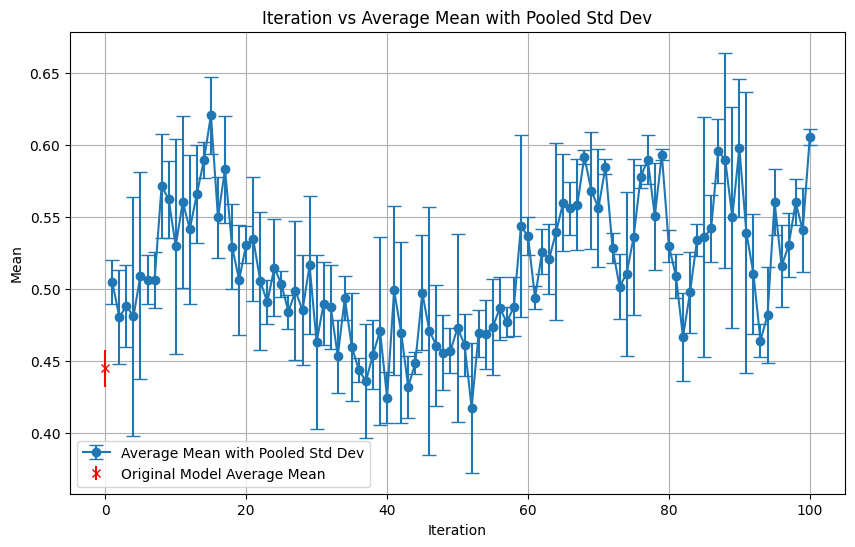

In [13]:
import re
import matplotlib.pyplot as plt
import ast
import numpy as np

# Function to parse the log file for both EVAL and Original model metrics
def parse_log_file(log_path):
    eval_pattern = re.compile(
        r"EVAL: Cosine_Sim metrics Training Set for iteration (\d+): (.+)"
    )
    original_model_pattern = re.compile(
        r"Original model metrics on training set: (.+)"
    )
    
    data = {"EVAL": {}, "Original": []}

    # Read the log file line by line
    with open(log_path, 'r') as log_file:
        for line in log_file:
            eval_match = eval_pattern.search(line)
            original_match = original_model_pattern.search(line)

            # If it's an EVAL line
            if eval_match:
                iteration = int(eval_match.group(1)) + 1  # Adding 1 to iteration as requested
                metrics_list = eval_match.group(2).strip()

                # Convert the metrics_list string to a Python object (list of dicts)
                metrics_list = ast.literal_eval(metrics_list)

                # Store means and std_devs for this iteration
                means = []
                std_devs = []
                counts = []

                for metrics in metrics_list:
                    mean = metrics['metrics']['mean']
                    std_dev = metrics['metrics']['std_dev']
                    count = len(metrics['metrics']['rewards'])  # Number of rewards is the sample size

                    means.append(mean)
                    std_devs.append(std_dev)
                    counts.append(count)

                # Store mean, std_dev, and count for each iteration
                data["EVAL"][iteration] = {
                    "means": means,
                    "std_devs": std_devs,
                    "counts": counts
                }

            # If it's an Original Model Metrics line
            elif original_match:
                metrics_list = original_match.group(1).strip()

                # Convert the metrics_list string to a Python object (list of dicts)
                metrics_list = ast.literal_eval(metrics_list)

                for metrics in metrics_list:
                    mean = metrics['metrics']['mean']
                    std_dev = metrics['metrics']['std_dev']
                    data["Original"].append((mean, std_dev))

    return data

# Function to calculate the pooled standard deviation
def pooled_std_dev(std_devs, counts):
    # Pooled variance formula
    numerator = sum((counts[i] - 1) * (std_devs[i] ** 2) for i in range(len(std_devs)))
    denominator = sum(counts[i] - 1 for i in range(len(counts)))

    if denominator > 0:
        pooled_variance = numerator / denominator
        return np.sqrt(pooled_variance)
    else:
        return 0  # In case of single value or no variance

# Function to plot iteration vs the average mean and pooled std_dev
def plot_metrics(data):
    plt.figure(figsize=(10, 6))

    # Plot EVAL data (average across all idx)
    iterations = sorted(data["EVAL"].keys())
    avg_means = []
    pooled_std_devs = []

    for iteration in iterations:
        means = data["EVAL"][iteration]["means"]
        std_devs = data["EVAL"][iteration]["std_devs"]
        counts = data["EVAL"][iteration]["counts"]

        # Calculate the average mean for the iteration
        avg_mean = sum(means) / len(means)
        avg_means.append(avg_mean)

        # Calculate the pooled standard deviation for the iteration
        pooled_std_dev_value = pooled_std_dev(std_devs, counts)
        pooled_std_devs.append(pooled_std_dev_value)

    # Plot the average means with pooled std_dev as error bars
    plt.errorbar(iterations, avg_means, yerr=pooled_std_devs, fmt='o-', capsize=5, label='Average Mean with Pooled Std Dev')

    # Plot Original Model data (if available)
    if "Original" in data and len(data["Original"]) > 0:
        original_means = [item[0] for item in data["Original"]]
        original_std_devs = [item[1] for item in data["Original"]]
        avg_original_mean = np.mean(original_means)
        pooled_original_std_dev = pooled_std_dev(original_std_devs, [10] * len(original_std_devs))  # Assuming 10 samples per idx

        plt.errorbar([0], [avg_original_mean], yerr=[pooled_original_std_dev], fmt='x', color='r', label='Original Model Average Mean')

    plt.xlabel('Iteration')
    plt.ylabel('Mean')
    plt.title('Iteration vs Average Mean with Pooled Std Dev')
    plt.grid(True)
    plt.legend()
    plt.show()


# Parse the log file
data = parse_log_file(log_path)

# Plot the metrics
plot_metrics(data)
